In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os as os
import nrrd as reader
import pandas as pd
import cv2 
import csv
from tqdm import tqdm
from tabulate import tabulate
from skimage import morphology
from skimage import measure
from skimage import segmentation
from skimage.segmentation import flood, flood_fill
from skimage.measure import label
from skimage.segmentation import active_contour
from skimage import data, io, img_as_ubyte,filters
from time import sleep
from IPython.display import clear_output

In [2]:
def join(one, two):
    return os.path.join(one, two)

def check_path(path):
    count=0
    for files in sorted(os.listdir(path)):
        image_path = os.path.join(path,files)
        count+=1
    return count

num_patients = int(check_path(join(os.getcwd(), "dataset")))
folder_path=join(os.getcwd(), "dataset")

for patient in sorted(os.listdir(folder_path)):
    patient_path = join(folder_path, patient)
    InputImage=sitk.ReadImage(sitk.ImageSeriesReader_GetGDCMSeriesFileNames(patient_path)) 
    inputs = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
    sortedpatients= sorted(os.listdir(folder_path))
    
slicesperpatient=InputImage.GetSize()[2]
totalslices=(num_patients * InputImage.GetSize()[2])
slicesperpatient=InputImage.GetSize()[2]


In [3]:
def dcm_to_np(path):
    global dic_count
    try:
        slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path)
        image = sitk.ReadImage(slice_filenames)
        for x in range(slicesperpatient):
            current_slice = image[:, :, x]
            current_array = sitk.GetArrayFromImage(current_slice)
            split_array = current_array[:,:-256]
            inputs[dic_count] = split_array[:, :, np.newaxis]
            dic_count+=1
        print(f'{patient} {R}/{num_patients}')
    except Exception as e:
        print(e)

def nrrd_to_np(meta_object,outputs):
    global ann_count
    try:
        data = sitk.GetArrayFromImage(meta_object)
        for p in range(slicesperpatient):
            current_seg = data[p, :, :]
            half_seg= current_seg[:,:-256]
            black = np.zeros([256, 256, 9])
            for y, a in enumerate(half_seg):
                for x, b in enumerate(a):
                    if b>0:
                        black[y][x][b-1] = 1
            outputs[ann_count] = black
            ann_count+=1
        print("Segmentation Imported")
    except Exception as e:
        print(e)

def fle_to_np(meta_object,outputs):
    global fle_count
    try:
        data = sitk.GetArrayFromImage(meta_object)
        for p in range(slicesperpatient):
            outputs[fle_count] = np.expand_dims(np.where(data[p, :, :256] == 1, 1, 0), axis=2)
            fle_count+=1
        print('FLE IMPORTED')        
    except Exception as e:
        print(e)

mskoutputs = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 9))
fleoutputs=np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
fle_count = 0
dic_count = 0
ann_count = 0
R=1
try:
    for patient in sorted(os.listdir(folder_path)):
        clear_output(wait=True)
        patient_path = join(folder_path, patient)
        nrrd_folder = join(patient_path, "NRRD")
        dcm_to_np(patient_path)
        for nrrd in os.listdir(nrrd_folder):
            if(".nrrd" in nrrd):
                segmentation = sitk.ReadImage(join(nrrd_folder, nrrd))
                nrrd_to_np(segmentation,mskoutputs)
        fle_folder = join(patient_path, "FLE")
        for fle in os.listdir(fle_folder):
            if(".nrrd" in fle):
                flesegmentation = sitk.ReadImage(join(fle_folder, fle))
                fle_to_np(flesegmentation,fleoutputs)
        R+=1
except Exception as e:
    print(e)

9000798 1/1
Segmentation Imported
FLE IMPORTED


In [4]:
#functions for inhomogeneity correction 
def correct_roi(image):
    inputImage=sitk.GetImageFromArray(image)
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output = corrector.Execute( inputImage)
    image_c= sitk.GetArrayFromImage(output)
    image_c=cv2.normalize(src=image_c, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #need to normalize, not direct conversion by "np.uint8"
    return image_c

def npnormalization (inputimage):
    for x in range (totalslices): #NumPy Normalization  
        clear_output(wait=True)
        temp = inputimage[x].reshape(256, 256)
        temp1= correct_roi(temp)
        np.linalg.norm(temp1)
        inputs[x]=temp1[:, :, np.newaxis]
        print(f'{x+1}/{totalslices} Slices |{round((x/totalslices)*100)}%|')
    print(f'Normalization Complete')
    return inputs

ImportedArray = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
ImportedArray = npnormalization (inputs)

15/15 Slices |93%|
Normalization Complete


Processing DICOMs with Imported Segmentations... Please Wait...
Pre Process-------------------------------------------


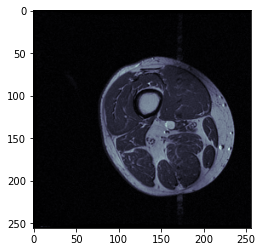

Post Process-------------------------------------------


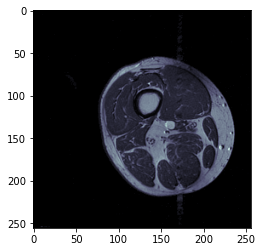

In [5]:
def imageprocessor(Array,Image,Segmentations,FLESegmentations):
    print("Processing DICOMs with Imported Segmentations... Please Wait...")
    imageI = Array[:, :, :, 0] #Inputs Variable 
    ArrayI = np.empty((num_patients * Image.GetSize()[2], int(Image.GetSize()[0]/2), int(Image.GetSize()[1]), 1))
    mskROI = np.empty((num_patients * Image.GetSize()[2], int(Image.GetSize()[0]/2), int(Image.GetSize()[1]), 1))
    fleoutputsI = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
    boneremoval = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
    for x in range (totalslices): 
        for i in range (9):
            if i !=2:
                ArrayI[x,:,:,0]+=Segmentations[x,:,:,i] #Merged MSK Mask
    FArrayI = FLESegmentations[:,:,:,0]
    boneremoval = Segmentations[:,:,:,2]
    ArrayII = ArrayI[:, :, :, 0] # Get rid of [:,:,:,1]
    INVArrayI = 1 - FArrayI #Invered Mask
    INVArrayII = INVArrayI * imageI #Mask multipled with array
    INVArrayIII = np.where(INVArrayII > (10), 1, 0)
    FArrayII = INVArrayIII + FArrayI #Add both the merged msk and inv msk together
    
    print("Pre Process-------------------------------------------")
    for i in range (0,totalslices,slicesperpatient):
        plt.imshow(imageI[i],cmap=plt.cm.bone,vmin=0,vmax=255)
        plt.show()
        
    FinalArray = FArrayII * imageI #Multiply new mask with original image
    mskROI = imageI * ArrayII
    fleROI = imageI * (FArrayI-boneremoval)
    print("Post Process-------------------------------------------")
    for i in range (0,totalslices,slicesperpatient):
        plt.imshow(FinalArray[i],cmap=plt.cm.bone,vmin=0,vmax=255)
        plt.show()
        
    return FinalArray,mskROI,fleROI,ArrayII

thigharray=np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1])))
ROI_MSK=np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1])))
ROI_FLE=np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1])))
OG_VOL=np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1])))
thigharray,ROI_MSK,ROI_FLE,OG_VOL=imageprocessor(ImportedArray,InputImage,mskoutputs,fleoutputs)


In [6]:
CorrectedFascia = np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1]), 1))
CorrectedFascia = npnormalization (ROI_FLE)
CorrectedFascia=CorrectedFascia[:,:,:,0]

15/15 Slices |93%|
Normalization Complete


In [7]:
def multi_otsu(image):
    motsuth=filters.threshold_multiotsu(image, classes=3)
    print(motsuth)
    print (f"Slice {i+1} otsu threshold={motsuth[1]}")
    regions=np.digitize(image,bins=motsuth)
    output=img_as_ubyte(regions)
    return motsuth[1] #(fat+ muscle th)

def ITSA(i,InROI, ots, OG_VOL):
    k=1
    ThPrev=0 
    ThRev= ots[i] 
    x=0
    y=0
    
    while ThRev!=ThPrev:
        ThPrev=ThRev
        prefatmask = (InROI[i]>ThRev)
        prefatmask = np.uint8(prefatmask)
        ret, fatmask = cv2.threshold(prefatmask,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next=OG_VOL[i+1]+fatmask
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_next
        elif i==(totalslices-1):
            fatcombined_prev=OG_VOL[i-1]+fatmask
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_prev  
        else:
            fatcombined_prev=OG_VOL[i-1]+fatmask
            fatcombined_next=fatmask+OG_VOL[i+1]
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)

            z_connection=fatconnectedparts_prev+fatconnectedparts_next
            ret, z_connection= cv2.threshold(z_connection,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates= np.argwhere(z_connection ==1) #put coordinates of Z-connections into a list      
        im_ff=fatmask.copy()
        h, w = im_ff.shape[:2] #added
        mask = np.zeros((h+2, w+2), np.uint8)
        for item in range(len(coordinates)):
            cv2.floodFill(im_ff, mask, (coordinates[item][1],coordinates[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ =label(im_ff==1)
        nonZ_keep = (morphology.remove_small_objects(nonZ,min_size=8, connectivity=1))
        ret, nonZ_keep= cv2.threshold(np.uint8(nonZ_keep),0,1,cv2.THRESH_BINARY)
        Z = (im_ff==2)
        prefatseg1=(Z+nonZ_keep) #do we need int cus boolean??
        fatseg1=prefatseg1*InROI[i]
        #Fat and Muscle Quantification
        preMuscSegP=InROI[i]-fatseg1
        MuscSegP=np.ma.masked_where(preMuscSegP == 0, preMuscSegP)
        MuscSeg = InROI[i]*MuscSegP
        FatSegP=np.ma.masked_where(fatseg1==0,fatseg1) 
        MuscSegI=np.mean(MuscSegP)
        FatSegI=np.mean(FatSegP)
        ThRev=(1+((FatSegI-MuscSegI)/FatSegI))*MuscSegI
        print (f"Slice #{i+1} Iteration={k}\n\tThPrev={ThPrev}\n\tThRev={ThRev}\n")

        k+=1
        if k==50:
            break

    thresholds = ThRev
    
    return fatseg1,thresholds


iThreshold=[]
print('Multi Otsu Threshold...')
for i in range(totalslices):
    iThreshold.append([])
    iThreshold[i]=multi_otsu(CorrectedFascia[i])
print ("-----------------------------------------------------------")

#ITSA Threshold Seeking Round 1 
fleROI_R1=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8')
fatseg=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8')
fatsegMASK=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8') #change name
threshold_R1=[] #change name compared to single slice?
print("ITSA Round 1 Initiation...")
for i in range(totalslices):
    threshold_R1.append([])
    fatseg[i],threshold_R1[i]=ITSA(i, CorrectedFascia, iThreshold,OG_VOL )  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Round 1 Th1 = {threshold_R1[i]}")
    print ("-----------------------------------------------------------")
    
for i in range(totalslices):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1[i]}")

Multi Otsu Threshold...
[25.40039062 89.15039062]
Slice 1 otsu threshold=89.150390625
[ 32.37304688 117.04101562]
Slice 2 otsu threshold=117.041015625
[ 34.36523438 124.01367188]
Slice 3 otsu threshold=124.013671875
[ 32.37304688 117.04101562]
Slice 4 otsu threshold=117.041015625
[ 32.37304688 116.04492188]
Slice 5 otsu threshold=116.044921875
[ 31.37695312 112.06054688]
Slice 6 otsu threshold=112.060546875
[ 31.37695312 112.06054688]
Slice 7 otsu threshold=112.060546875
[ 34.36523438 117.04101562]
Slice 8 otsu threshold=117.041015625
[27.39257812 94.13085938]
Slice 9 otsu threshold=94.130859375
[ 33.36914062 116.04492188]
Slice 10 otsu threshold=116.044921875
[ 33.36914062 118.03710938]
Slice 11 otsu threshold=118.037109375
[ 33.36914062 116.04492188]
Slice 12 otsu threshold=116.044921875
[ 32.37304688 112.06054688]
Slice 13 otsu threshold=112.060546875
[ 30.38085938 106.08398438]
Slice 14 otsu threshold=106.083984375
[ 32.37304688 110.06835938]
Slice 15 otsu threshold=110.068359375
-

/Users/jasontsang/opt/anaconda3/lib/python3.8/site-packages/skimage/util/dtype.py:525: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)


Slice #4 Iteration=2
	ThPrev=103.82959883427172
	ThRev=100.71448001125566

Slice #4 Iteration=3
	ThPrev=100.71448001125566
	ThRev=99.99666555050969

Slice #4 Iteration=4
	ThPrev=99.99666555050969
	ThRev=99.6561422385043

Slice #4 Iteration=5
	ThPrev=99.6561422385043
	ThRev=99.6561422385043

Slice #4 Round 1 Th1 = 99.6561422385043
-----------------------------------------------------------
Slice #5 Iteration=1
	ThPrev=116.044921875
	ThRev=102.23757956175804

Slice #5 Iteration=2
	ThPrev=102.23757956175804
	ThRev=98.98969339923994

Slice #5 Iteration=3
	ThPrev=98.98969339923994
	ThRev=97.93357257210437

Slice #5 Iteration=4
	ThPrev=97.93357257210437
	ThRev=97.5994744260395

Slice #5 Iteration=5
	ThPrev=97.5994744260395
	ThRev=97.5994744260395

Slice #5 Round 1 Th1 = 97.5994744260395
-----------------------------------------------------------
Slice #6 Iteration=1
	ThPrev=112.060546875
	ThRev=99.79850714740375

Slice #6 Iteration=2
	ThPrev=99.79850714740375
	ThRev=96.48948624017102

Slice 

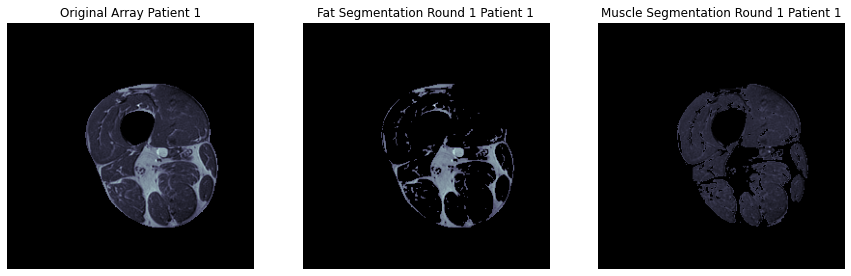

In [8]:
def PatientViewer (Array, ArrayN, Array1, ArrayN1, Array2, ArrayN2):
    'Array, Array Name, .. 2 , ... 3 '
    s=1
    for i in range (0,totalslices,slicesperpatient):
        fig, axs=plt.subplots (1,3, figsize=(15,10))
        axs[0].imshow(Array[i],"bone",vmin=0,vmax=256)
        axs[0].set_title(f'{ArrayN} Patient {s}')
        axs[0].axis("off")
        axs[1].imshow(Array1[i],"bone",vmax=256)
        axs[1].set_title(f'{ArrayN1} Patient {s}')
        axs[1].axis("off")
        axs[2].imshow(Array2[i],"bone",vmin=0,vmax=255)
        axs[2].set_title(f'{ArrayN2} Patient {s}')
        axs[2].axis("off")
        s+=1

fleROI_R1=CorrectedFascia-fatseg
PatientViewer(CorrectedFascia,"Original Array",fatseg,"Fat Segmentation Round 1",fleROI_R1,"Muscle Segmentation Round 1")

In [9]:
#ITSA Threshold Seeking Round 2
print('Multi Otsu Threshold Round 2...')
iThresholdR2=[]
for i in range(totalslices):
    iThresholdR2.append([])
    iThresholdR2[i]=multi_otsu(fleROI_R1[i])
    
fatsegR2=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8') 
threshold_R2=[] 
for i in range(totalslices):
    threshold_R2.append([])
    fatsegR2[i], threshold_R2[i]=ITSA(i, fleROI_R1, iThresholdR2, OG_VOL)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    
    print (f"Slice #{i+1} Round 2 Threshold = {threshold_R2[i]}")
    print ("-----------------------------------------------------------")
for i in range(totalslices):
    print (f"Slice #{i+1} Th2 OG/Rev={threshold_R2[i]}")

Multi Otsu Threshold Round 2...
[20.93945312 51.02148438]
Slice 1 otsu threshold=51.021484375
[28.03125 66.21875]
Slice 2 otsu threshold=66.21875
[29.73632812 70.06835938]
Slice 3 otsu threshold=70.068359375
[27.84375 67.71875]
Slice 4 otsu threshold=67.71875
[27.234375 63.984375]
Slice 5 otsu threshold=63.984375
[27.1171875 63.0703125]
Slice 6 otsu threshold=63.0703125
[26.90234375 62.95703125]
Slice 7 otsu threshold=62.95703125
[28.99804688 68.04492188]
Slice 8 otsu threshold=68.044921875
[24.06640625 56.94921875]
Slice 9 otsu threshold=56.94921875
[28.0546875 66.0234375]
Slice 10 otsu threshold=66.0234375
[29.21875 67.71875]
Slice 11 otsu threshold=67.71875
[28.98632812 67.83398438]
Slice 12 otsu threshold=67.833984375
[27.09179688 63.95898438]
Slice 13 otsu threshold=63.958984375
[26.24804688 59.86914062]
Slice 14 otsu threshold=59.869140625
[29.24414062 66.97851562]
Slice 15 otsu threshold=66.978515625
Slice #1 Iteration=1
	ThPrev=51.021484375
	ThRev=54.895710041049874

Slice #1 I

## ERROR CORRECTION

In [10]:
# TOTAL SLICES IS MY PRE SET NUMBER OF SLICES

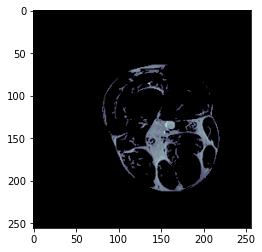

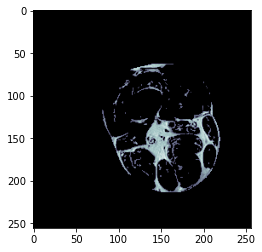

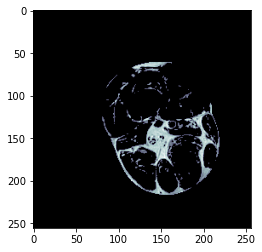

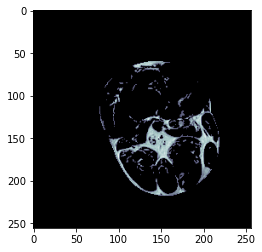

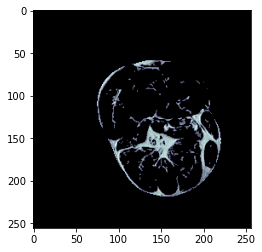

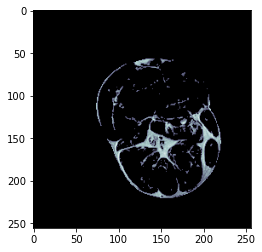

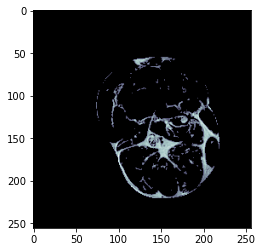

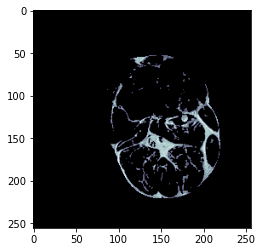

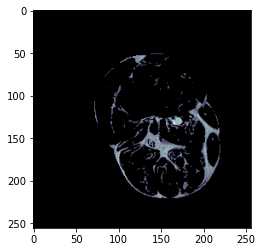

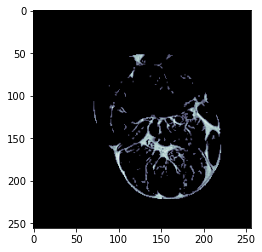

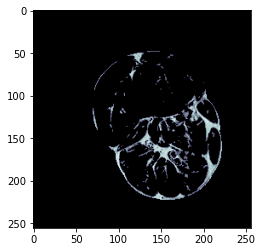

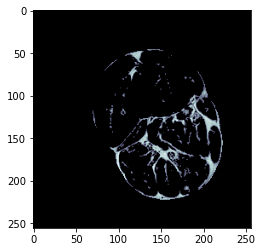

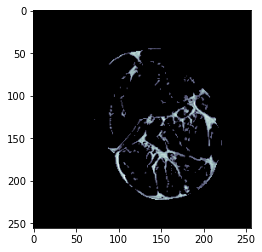

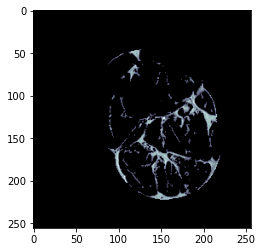

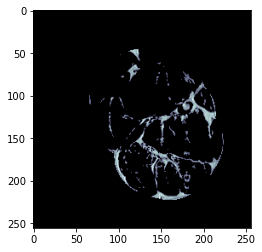

In [13]:
def errorcorrection (FatSegRound2,FatSegRound1,MuscleSegRound1,thigharray):    
    musclemean=[]
    musclestd=[]
    MUSCLETHRES=[]
    ThresCorrectedFat=np.empty([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8') 
    
    for i in range (thigharray.shape[0]):
        musclemean.append([])
        musclestd.append([])
        MUSCLETHRES.append([])
        
        musclemean[i]=np.mean([x for x in MuscleSegRound1[i].flatten() if x > 0])
        musclestd[i]=np.std([x for x in MuscleSegRound1[i].flatten() if x > 0])
        MUSCLETHRES[i] = musclemean[i]+(1.96*musclestd[i])
        
        ThresCorrectedFat[i] = np.where(FatSegRound2[i] > MUSCLETHRES[i], FatSegRound2[i], 0) 
        
    combinedfat= ThresCorrectedFat+FatSegRound1
    plchdr,pre3dfat = cv2.threshold(combinedfat,0,1,cv2.THRESH_BINARY)
    PostZConnectFat = np.empty([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8') 
    
    for i in range (thigharray.shape[0]):
        if i==0:
            fatcombined_next=pre3dfat[i+1]+pre3dfat[i]
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_next
        elif i==(totalslices-1):
            fatcombined_prev=pre3dfat[i-1]+pre3dfat[i]
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_prev  
        else:
            fatcombined_prev=pre3dfat[i-1]+pre3dfat[i]
            fatcombined_next=pre3dfat[i]+pre3dfat[i+1]
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)

            z_connection=fatconnectedparts_prev+fatconnectedparts_next
            ret, z_connection= cv2.threshold(z_connection,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates= np.argwhere(z_connection ==1)    
        im_ff=pre3dfat[i].copy()
        h, w = im_ff.shape[:2] #added
        mask = np.zeros((h+2, w+2), np.uint8)
        for item in range(len(coordinates)):
            cv2.floodFill(im_ff, mask, (coordinates[item][1],coordinates[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ =label(im_ff==1)
        nonZ_keep = (morphology.remove_small_objects(nonZ,min_size=8, connectivity=1))
        ret, nonZ_keep= cv2.threshold(np.uint8(nonZ_keep),0,1,cv2.THRESH_BINARY)
        Z = (im_ff==2)
        PostZConnectFat[i]=(Z+nonZ_keep)

    FinalFatSeg=thigharray*PostZConnectFat
    return FinalFatSeg


test=np.empty((num_patients * InputImage.GetSize()[2], int(InputImage.GetSize()[0]/2), int(InputImage.GetSize()[1])))
test=errorcorrection(fatsegR2,fatseg,fleROI_R1,thigharray)  


for i in range (totalslices):
    plt.imshow(test[i],cmap='bone',)
    plt.show()